In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
def calculate_measured_psd(ux, uy, fs=1, return_ref=False, direction="along"):
    u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
    beta_bar = np.arctan2(np.mean(uy), np.mean(ux))
    if direction == "along":
        uu = ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar
    else:
        uu = -ux * np.sin(beta_bar) + uy * np.cos(beta_bar)
    
    frequencies, psd = signal.welch(uu, fs=fs, window='hamming', 
                                   scaling='density', nperseg=1024)
    frequencies = frequencies[1:]
    psd = psd[1:]
    if not return_ref:
        return frequencies, psd
    z = 76
    z0 = 0.01
    H_ = 0
    K = 0.4
    zd = H_ - z0 / K
    u_star = K * u_bar / np.log((z - zd) / z0)
    f = frequencies * z / u_bar
    reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies
    return frequencies, psd, reference_psd

In [4]:
def read_one_file(path, return_if_data_loss=False, need_fill=True):
    # Read one raw data file in one hour.
    if_data_loss = False
    with open(path, "r") as f:
        lines = f.readlines()[1:]
    data = []
    for line in lines:
        line = line.strip().split(",")[:2]
        line = list(map(float, line))
        data.append(line)
    data = np.array(data)
    if data.shape[0] < 3600:
        warnings.warn("Data length is less than 3600.")
        if need_fill:
            data = np.vstack([data, np.zeros((3600 - data.shape[0], 2))])
        if_data_loss = True
    if data.shape[0] > 3600:
        warnings.warn("Data length is more than 3600.")
        data = data[:3600]
    if return_if_data_loss:
        return data, if_data_loss
    else:
        return data

data = read_one_file("./data/bridge_measurement.FS")
data[:, 1] = np.deg2rad(data[:, 1])
ux = data[:, 0] * np.cos(data[:, 1])
uy = data[:, 0] * np.sin(data[:, 1])

frequencies, psd, reference_psd = calculate_measured_psd(ux, uy, return_ref=True)

In [5]:
mean_wind_speed = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
u10 = mean_wind_speed / (76/10)**0.12
mean_wind_speed, u10

(np.float64(12.26653361694102), np.float64(9.616659127605448))

In [10]:

from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type="kaimal-nd")
simulator.update_parameters(
    H_bar=0.0,
    z_0=0.01,
    T=3600,
    M=3600,
    N=1800,
    dt=1,
    U_d=u10,
    alpha_0=0.12,
    w_up=0.5,
)
n = 100
Z = 76
position = np.zeros((n, 3))
position[:, 2] = Z
position[:, 1] = 5
position[:, 0] = np.linspace(0, 1092, n)
wind_speeds = np.ones_like(position[:, 0]) * mean_wind_speed
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[50], fs=1, window='hamming', 
                                   scaling='density', nperseg=1024)

In [11]:
frequencies_sim.shape

(513,)

In [12]:
# visualizer = get_visualizer(backend="jax", key=42, simulator=simulator)
# visualizer.plot_psd(samples, position[:, -1], show_num=6, show=True, component="u")

[Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (m$^2$/s)')]

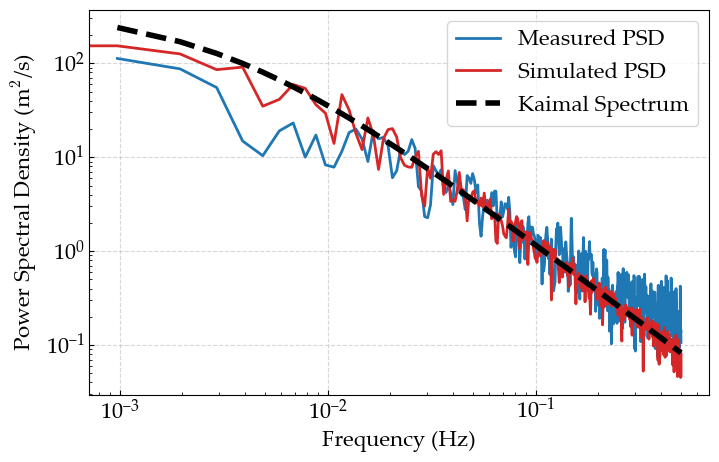

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies, psd, label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
# fig.savefig("./img/bridge_wind_spectrum.pdf", bbox_inches="tight")
# fig.savefig("./img/bridge_wind_spectrum.png", bbox_inches="tight", dpi=300)

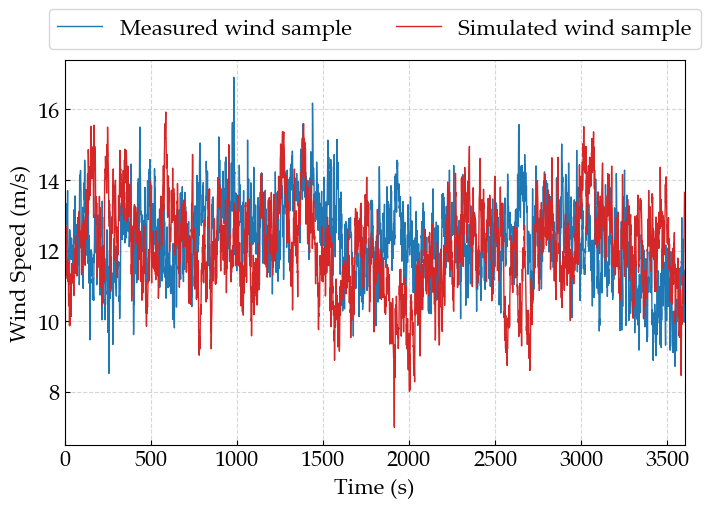

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(data[:, 0], label="Measured wind sample", color="C0", lw=1)
ax.plot(samples[50]+wind_speeds[50], label="Simulated wind sample", color="C3", 
        linestyle="solid", lw=1,)
ax.legend(ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax.set(xlabel="Time (s)", ylabel="Wind Speed (m/s)", xlim=(0, 3600))
fig.savefig("./img/bridge_wind_timehistory.pdf", bbox_inches="tight")
fig.savefig("./img/bridge_wind_timehistory.png", bbox_inches="tight", dpi=300)